In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Classifiers
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler




In [2]:
df = pd.read_csv("digital_marketing_campaign_dataset.csv")

In [3]:
df.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


In [4]:
df.describe(include='all')

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
count,8000.00000,8000.000000,8000,8000.000000,8000,8000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000,8000,8000.000000
unique,NaN,NaN,2,NaN,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN
top,NaN,NaN,Female,NaN,Referral,Conversion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IsConfid,ToolConfid,NaN
freq,NaN,NaN,4839,NaN,1719,2077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000,8000,NaN
mean,11999.50000,43.625500,NaN,84664.196750,NaN,NaN,5000.944830,0.154829,0.104389,24.751625,5.549299,7.727718,49.799750,9.476875,4.467375,4.485500,2490.268500,NaN,NaN,0.876500
std,2309.54541,14.902785,NaN,37580.387945,NaN,NaN,2838.038153,0.084007,0.054878,14.312269,2.607358,4.228218,28.901165,5.711111,2.856564,2.888093,1429.527162,NaN,NaN,0.329031
min,8000.00000,18.000000,NaN,20014.000000,NaN,NaN,100.054813,0.010005,0.010018,0.000000,1.000428,0.501669,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,9999.75000,31.000000,NaN,51744.500000,NaN,NaN,2523.221165,0.082635,0.056410,13.000000,3.302479,4.068340,25.000000,5.000000,2.000000,2.000000,1254.750000,NaN,NaN,1.000000
50%,11999.50000,43.000000,NaN,84926.500000,NaN,NaN,5013.440044,0.154505,0.104046,25.000000,5.534257,7.682956,50.000000,9.000000,4.000000,4.000000,2497.000000,NaN,NaN,1.000000
75%,13999.25000,56.000000,NaN,116815.750000,NaN,NaN,7407.989369,0.228207,0.152077,37.000000,7.835756,11.481468,75.000000,14.000000,7.000000,7.000000,3702.250000,NaN,NaN,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           8000 non-null   int64  
 1   Age                  8000 non-null   int64  
 2   Gender               8000 non-null   object 
 3   Income               8000 non-null   int64  
 4   CampaignChannel      8000 non-null   object 
 5   CampaignType         8000 non-null   object 
 6   AdSpend              8000 non-null   float64
 7   ClickThroughRate     8000 non-null   float64
 8   ConversionRate       8000 non-null   float64
 9   WebsiteVisits        8000 non-null   int64  
 10  PagesPerVisit        8000 non-null   float64
 11  TimeOnSite           8000 non-null   float64
 12  SocialShares         8000 non-null   int64  
 13  EmailOpens           8000 non-null   int64  
 14  EmailClicks          8000 non-null   int64  
 15  PreviousPurchases    8000 non-null   i

In [6]:
df['Conversion'].value_counts()

Conversion
1    7012
0     988
Name: count, dtype: int64

In [7]:
df.isnull().sum()

CustomerID             0
Age                    0
Gender                 0
Income                 0
CampaignChannel        0
CampaignType           0
AdSpend                0
ClickThroughRate       0
ConversionRate         0
WebsiteVisits          0
PagesPerVisit          0
TimeOnSite             0
SocialShares           0
EmailOpens             0
EmailClicks            0
PreviousPurchases      0
LoyaltyPoints          0
AdvertisingPlatform    0
AdvertisingTool        0
Conversion             0
dtype: int64

In [8]:
for column in df.columns:
    if df[column].dtype == 'object':
        print(f"Value counts for column '{column}':")
        print(df[column].value_counts())
        print("\n" + "-"*50 + "\n")

Value counts for column 'Gender':
Gender
Female    4839
Male      3161
Name: count, dtype: int64

--------------------------------------------------

Value counts for column 'CampaignChannel':
CampaignChannel
Referral        1719
PPC             1655
Email           1557
SEO             1550
Social Media    1519
Name: count, dtype: int64

--------------------------------------------------

Value counts for column 'CampaignType':
CampaignType
Conversion       2077
Awareness        1988
Consideration    1988
Retention        1947
Name: count, dtype: int64

--------------------------------------------------

Value counts for column 'AdvertisingPlatform':
AdvertisingPlatform
IsConfid    8000
Name: count, dtype: int64

--------------------------------------------------

Value counts for column 'AdvertisingTool':
AdvertisingTool
ToolConfid    8000
Name: count, dtype: int64

--------------------------------------------------



Here in the above Cell we noticed **AdvertisingTool** and **AdvertisingPlatform** are having exactly same values for all the entries and are thus not useful for us. we  will therefore drop those

In [9]:
df.drop(['AdvertisingTool','AdvertisingPlatform'],axis=1,inplace=True)

As the **CustomerID** doesn't come much into play either we will be removing that as well

In [10]:
df.drop('CustomerID',axis=1,inplace=True)

In [11]:
df.head()

,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
0,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,1
1,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,1
2,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,1
3,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,1
4,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,1


In [12]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# List of columns for encoding
binary_columns = ['Gender']
categorical_columns = ['CampaignChannel', 'CampaignType']

# 1. Encode binary columns (Label Encoding)
for col in binary_columns:
    df[col] = label_encoder.fit_transform(df[col])

# 2. Encode categorical columns (One-Hot Encoding)
df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

In [13]:

# 3. Display the encoded DataFrame
print("Encoded DataFrame:")
df

Encoded DataFrame:


,Age,Gender,Income,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,...,Conversion,CampaignChannel_Email,CampaignChannel_PPC,CampaignChannel_Referral,CampaignChannel_SEO,CampaignChannel_Social Media,CampaignType_Awareness,CampaignType_Consideration,CampaignType_Conversion,CampaignType_Retention
0,56,0,136912,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,...,1,False,False,False,False,True,True,False,False,False
1,69,1,41760,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,...,1,True,False,False,False,False,False,False,False,True
2,46,0,88456,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,...,1,False,True,False,False,False,True,False,False,False
3,32,0,44085,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,...,1,False,True,False,False,False,False,False,True,False
4,60,0,83964,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,...,1,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,21,1,24849,8518.308575,0.243792,0.116773,23,9.693602,14.227794,70,...,0,True,False,False,False,False,True,False,False,False
7996,43,0,44718,1424.613446,0.236740,0.190061,49,9.499010,3.501106,52,...,0,False,False,False,True,False,False,False,False,True
7997,28,0,125471,4609.534635,0.056526,0.133826,35,2.853241,14.618323,38,...,1,False,False,True,False,False,False,True,False,False
7998,19,0,107862,9476.106354,0.023961,0.138386,49,1.002964,3.876623,86,...,1,False,True,False,False,False,False,True,False,False


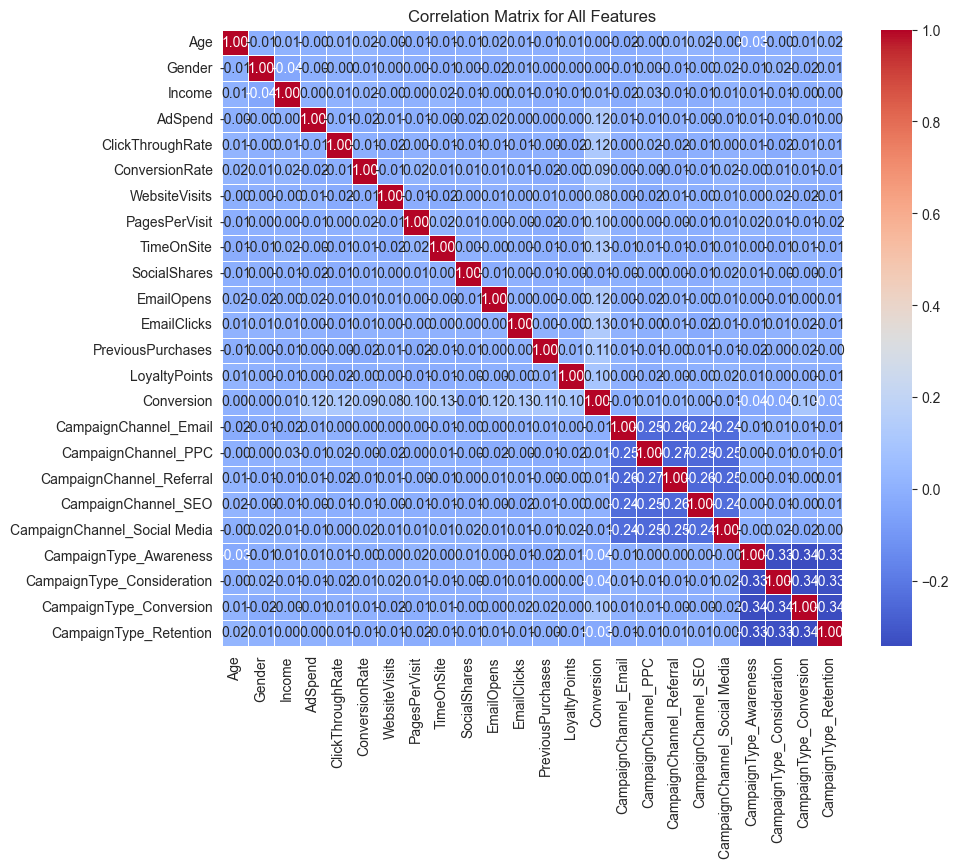

C:\Users\admin\AppData\Local\Temp\ipykernel_13480\1010501439.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion_corr.index, y=conversion_corr.values, palette=colors)  # Use custom colors


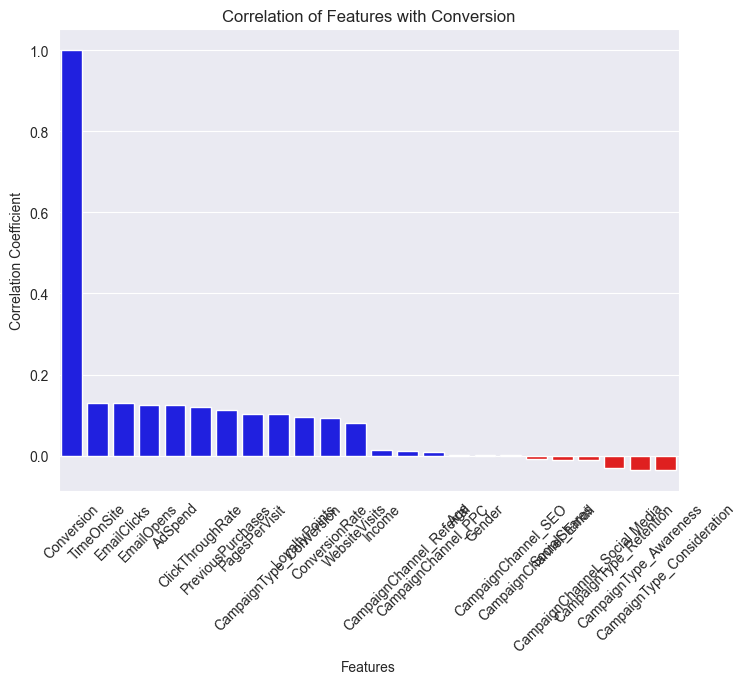

In [14]:
corr_matrix = df.corr()

# Plot the full correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, cbar=True)
plt.title('Correlation Matrix for All Features')
plt.show()

# 2. Calculate correlation of each feature with the 'Conversion' column
conversion_corr = corr_matrix['Conversion'].sort_values(ascending=False)

# 3. Define color list for positive and negative correlations
colors = ['blue' if x > 0 else 'red' for x in conversion_corr.values]

# Plot the correlation of features with 'Conversion' with two colors
plt.figure(figsize=(8, 6))
sns.barplot(x=conversion_corr.index, y=conversion_corr.values, palette=colors)  # Use custom colors
plt.title('Correlation of Features with Conversion')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

In [15]:
#Split data into features (X) and target (y)
X = df.drop(columns=['Conversion'])  # All columns except 'Conversion'
y = df['Conversion']  # Target column

#Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#Split data into train (80%) and test (20%) sets
X_trainval, X_test, y_trainval, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#From the training data (80%), split into train (85%) and validation (15%) sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

#Take 1% of the final training data for quicker hyperparameter tuning
X_small, _, y_small, _ = train_test_split(X_train, y_train, test_size=0.99, random_state=42, stratify=y_train)

# Helper to store results
results = {}

# --- Scaling for models that require it ---
scaler = StandardScaler()
X_small_scaled = scaler.fit_transform(X_small)
X_val_scaled = scaler.transform(X_val)
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

results = {}

### Logistic Regression (requires scaling)
model = LogisticRegression(max_iter=200000)
params = {'C': [0.01, 0.1, 1, 10]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small_scaled, y_small)
results["LogisticRegression"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val_scaled)))

### Ridge Classifier (requires scaling)
model = RidgeClassifier()
params = {'alpha': [0.01, 0.1, 1, 10]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small_scaled, y_small)
results["RidgeClassifier"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val_scaled)))

### SGD Classifier (requires scaling)
model = SGDClassifier(loss='log_loss', max_iter=1000)
params = {'alpha': [0.0001, 0.001, 0.01]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small_scaled, y_small)
results["SGDClassifier"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val_scaled)))

### SVM (requires scaling)
model = SVC()
params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small_scaled, y_small)
results["SVC"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val_scaled)))

### Decision Tree (no scaling)
model = DecisionTreeClassifier()
params = {'max_depth': [3, 5, 10]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["DecisionTree"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### Random Forest (no scaling)
model = RandomForestClassifier()
params = {'n_estimators': [50, 100], 'max_depth': [5, 10]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["RandomForest"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### Extra Trees (no scaling)
model = ExtraTreesClassifier()
params = {'n_estimators': [50, 100]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["ExtraTrees"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### Bagging Classifier (no scaling)
model = BaggingClassifier()
params = {'n_estimators': [10, 50]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["BaggingClassifier"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### AdaBoost (no scaling)
model = AdaBoostClassifier()
params = {'n_estimators': [50, 100]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["AdaBoost"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### Gradient Boosting (no scaling)
model = GradientBoostingClassifier()
params = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["GradientBoosting"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### XGBoost (no scaling)
model = XGBClassifier(eval_metric='logloss')
params = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["XGBoost"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### LightGBM (no scaling)
model = LGBMClassifier()
params = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["LightGBM"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### CatBoost (no scaling)
model = CatBoostClassifier(train_dir='./catboost_info', verbose=0)
params = {'iterations': [100], 'learning_rate': [0.01, 0.1]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["CatBoost"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### GaussianNB (no scaling)
model = GaussianNB()
gs = GridSearchCV(model, {}, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["GaussianNB"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### MultinomialNB (no scaling)
model = MultinomialNB()
gs = GridSearchCV(model, {}, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["MultinomialNB"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### BernoulliNB (no scaling)
model = BernoulliNB()
gs = GridSearchCV(model, {}, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["BernoulliNB"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### ComplementNB (no scaling)
model = ComplementNB()
gs = GridSearchCV(model, {}, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["ComplementNB"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### KNN (requires scaling)
model = KNeighborsClassifier()
params = {'n_neighbors': [3, 5, 7]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small_scaled, y_small)
results["KNN"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val_scaled)))

### MLPClassifier (requires scaling)
model = MLPClassifier(max_iter=500)
params = {'hidden_layer_sizes': [(50,), (100,), (100, 50)], 'alpha': [0.0001, 0.001]}
gs = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small_scaled, y_small)
results["MLPClassifier"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val_scaled)))

### Linear Discriminant Analysis (LDA) (no scaling)
model = LinearDiscriminantAnalysis()
gs = GridSearchCV(model, {}, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["LDA"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))

### Quadratic Discriminant Analysis (QDA) (no scaling)
model = QuadraticDiscriminantAnalysis()
gs = GridSearchCV(model, {}, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_small, y_small)
results["QDA"] = (gs.best_estimator_, accuracy_score(y_val, gs.predict(X_val)))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 47, number of negative: 48
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 95, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494737 -> initscore=-0.021053
[LightGBM] [Info] Start training from score -0.021053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

D:\Digital_marketing_Campaign_Conversion_prediction\venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [16]:
# --- Sort and print results ---
sorted_results = sorted(results.items(), key=lambda x: x[1][1])
print("\nModels sorted by validation accuracy (lowest to highest):")
for name, (estimator, acc) in sorted_results:
    print(f"{name}: {acc:.4f}")

# --- Select best model ---
best_model_name, (best_estimator, best_acc) = sorted_results[-1]
print(f"\nBest model: {best_model_name} with validation accuracy: {best_acc:.4f}")



Models sorted by validation accuracy (lowest to highest):
MultinomialNB: 0.5544
ComplementNB: 0.5544
DecisionTree: 0.6322
BernoulliNB: 0.7053
GradientBoosting: 0.7338
BaggingClassifier: 0.7469
CatBoost: 0.7499
GaussianNB: 0.7510
KNN: 0.7534
XGBoost: 0.7594
AdaBoost: 0.7629
LightGBM: 0.7689
RandomForest: 0.7932
ExtraTrees: 0.8021
SVC: 0.8354
SGDClassifier: 0.8360
MLPClassifier: 0.8419
LogisticRegression: 0.8479
RidgeClassifier: 0.8687
LDA: 0.8699
QDA: 0.8948

Best model: QDA with validation accuracy: 0.8948


In [17]:
# --- Retrain best model on full trainval and test ---

if best_model_name in ["LogisticRegression", "RidgeClassifier", "SGDClassifier", "SVC", "KNN", "MLPClassifier"]:
    # Scale trainval and test
    best_estimator.fit(X_trainval_scaled, y_trainval)
    y_test_pred = best_estimator.predict(X_test_scaled)
else:
    best_estimator.fit(X_trainval, y_trainval)
    y_test_pred = best_estimator.predict(X_test)

from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy of best model ({best_model_name}): {test_accuracy:.4f}")


Test accuracy of best model (QDA): 0.8966


D:\Digital_marketing_Campaign_Conversion_prediction\venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(



--- LogisticRegression ---
Age: -0.0141
Gender: 0.2767
Income: -0.0925
AdSpend: 0.3185
ClickThroughRate: 0.1415
ConversionRate: 0.2964
WebsiteVisits: 0.2165
PagesPerVisit: 0.2342
TimeOnSite: 0.4183
SocialShares: 0.1248
EmailOpens: 0.3036
EmailClicks: 0.1971
PreviousPurchases: 0.4173
LoyaltyPoints: 0.2503
CampaignChannel_Email: -0.3418
CampaignChannel_PPC: -0.1000
CampaignChannel_Referral: -0.3139
CampaignChannel_SEO: -0.2867
CampaignChannel_Social Media: -0.3697
CampaignType_Awareness: -0.4570
CampaignType_Consideration: -0.3877
CampaignType_Conversion: -0.0457
CampaignType_Retention: -0.2009


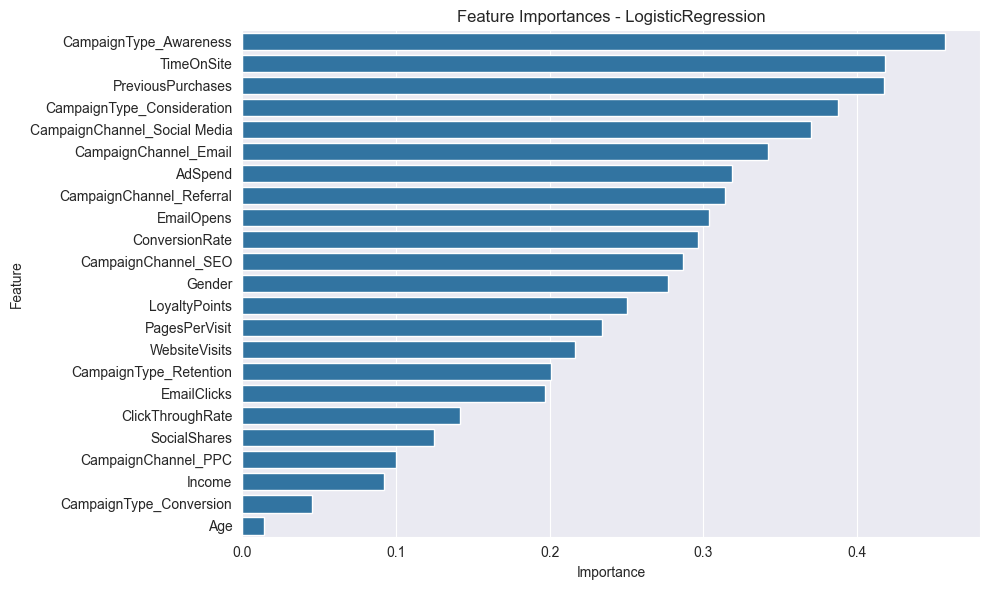


--- RidgeClassifier ---
Age: -0.0501
Gender: 0.0952
Income: -0.0456
AdSpend: 0.1296
ClickThroughRate: 0.0535
ConversionRate: 0.1327
WebsiteVisits: 0.0934
PagesPerVisit: 0.1024
TimeOnSite: 0.2082
SocialShares: 0.0615
EmailOpens: 0.0895
EmailClicks: 0.0722
PreviousPurchases: 0.2147
LoyaltyPoints: 0.0698
CampaignChannel_Email: -0.2869
CampaignChannel_PPC: -0.0956
CampaignChannel_Referral: -0.2554
CampaignChannel_SEO: -0.2433
CampaignChannel_Social Media: -0.2446
CampaignType_Awareness: -0.2567
CampaignType_Consideration: -0.2415
CampaignType_Conversion: -0.1044
CampaignType_Retention: -0.1174


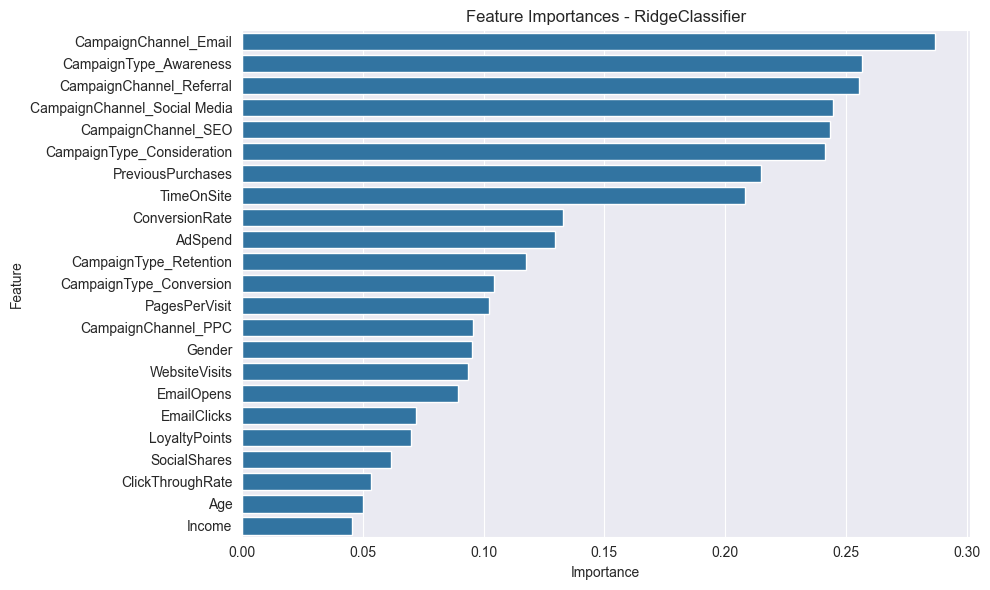


--- SGDClassifier ---
Age: -13.4958
Gender: 20.9677
Income: -6.0143
AdSpend: 11.1467
ClickThroughRate: -3.8233
ConversionRate: 23.7053
WebsiteVisits: 6.3181
PagesPerVisit: 4.9740
TimeOnSite: 53.3716
SocialShares: 6.3898
EmailOpens: 5.7686
EmailClicks: 5.7002
PreviousPurchases: 48.8230
LoyaltyPoints: 10.5484
CampaignChannel_Email: -60.0770
CampaignChannel_PPC: -19.5868
CampaignChannel_Referral: -33.5643
CampaignChannel_SEO: -40.8277
CampaignChannel_Social Media: -19.5556
CampaignType_Awareness: -56.9057
CampaignType_Consideration: -38.6839
CampaignType_Conversion: -27.1363
CampaignType_Retention: -34.1544


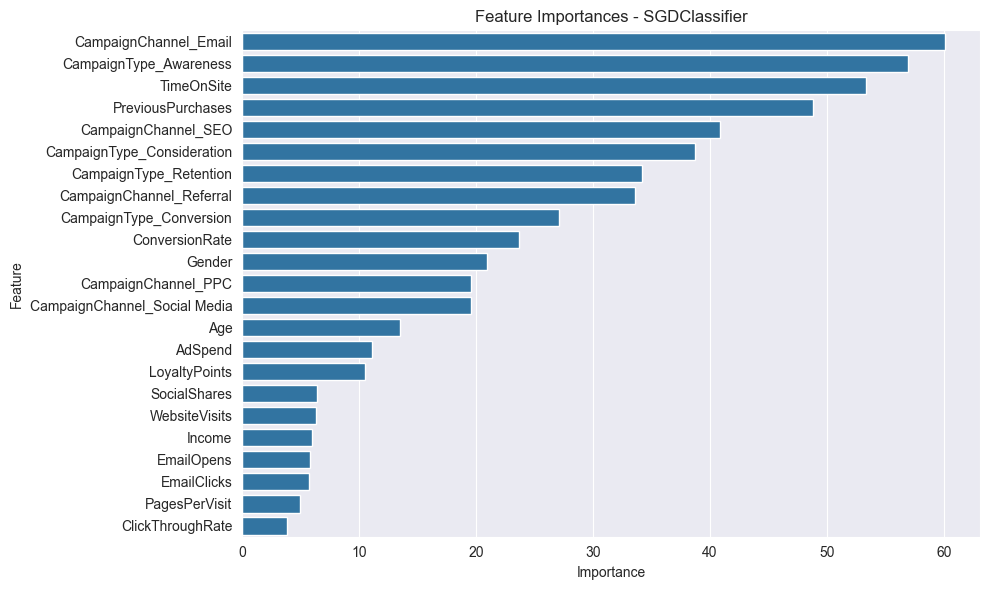


--- SVC ---
Age: 0.0000
Gender: 0.0000
Income: 0.0000
AdSpend: 0.0000
ClickThroughRate: 0.0000
ConversionRate: 0.0000
WebsiteVisits: 0.0000
PagesPerVisit: 0.0000
TimeOnSite: 0.0000
SocialShares: 0.0000
EmailOpens: 0.0000
EmailClicks: 0.0000
PreviousPurchases: 0.0000
LoyaltyPoints: 0.0000
CampaignChannel_Email: 0.0000
CampaignChannel_PPC: 0.0000
CampaignChannel_Referral: 0.0000
CampaignChannel_SEO: 0.0000
CampaignChannel_Social Media: 0.0000
CampaignType_Awareness: 0.0000
CampaignType_Consideration: 0.0000
CampaignType_Conversion: 0.0000
CampaignType_Retention: 0.0000


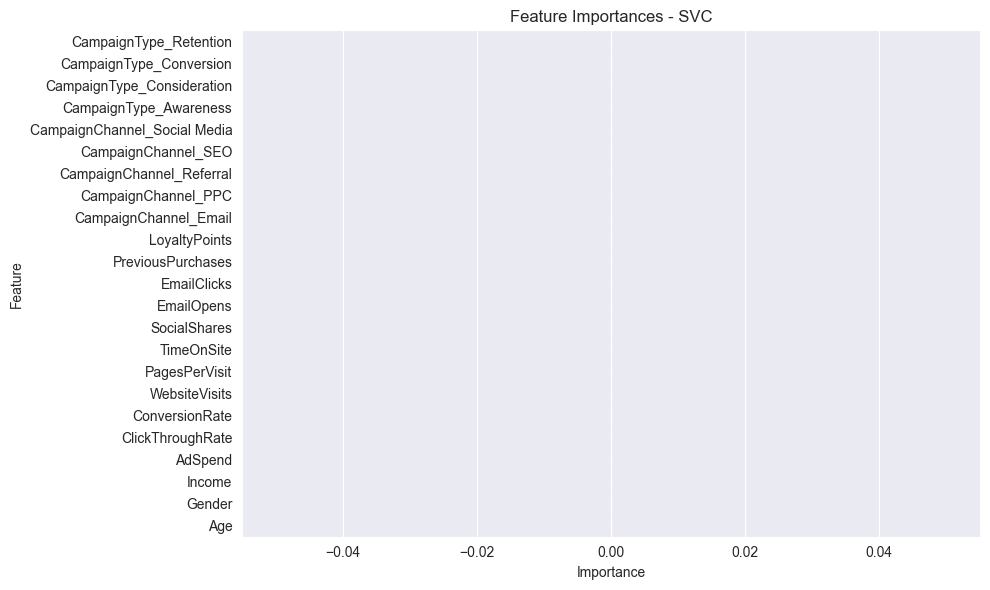


--- DecisionTree ---
Age: 0.0000
Gender: 0.0000
Income: 0.0000
AdSpend: 0.0975
ClickThroughRate: 0.2172
ConversionRate: 0.0000
WebsiteVisits: 0.0000
PagesPerVisit: 0.0000
TimeOnSite: 0.2133
SocialShares: 0.0000
EmailOpens: 0.3594
EmailClicks: 0.0000
PreviousPurchases: 0.0000
LoyaltyPoints: 0.0000
CampaignChannel_Email: 0.0000
CampaignChannel_PPC: 0.0000
CampaignChannel_Referral: 0.0000
CampaignChannel_SEO: 0.0000
CampaignChannel_Social Media: 0.0000
CampaignType_Awareness: 0.1126
CampaignType_Consideration: 0.0000
CampaignType_Conversion: 0.0000
CampaignType_Retention: 0.0000


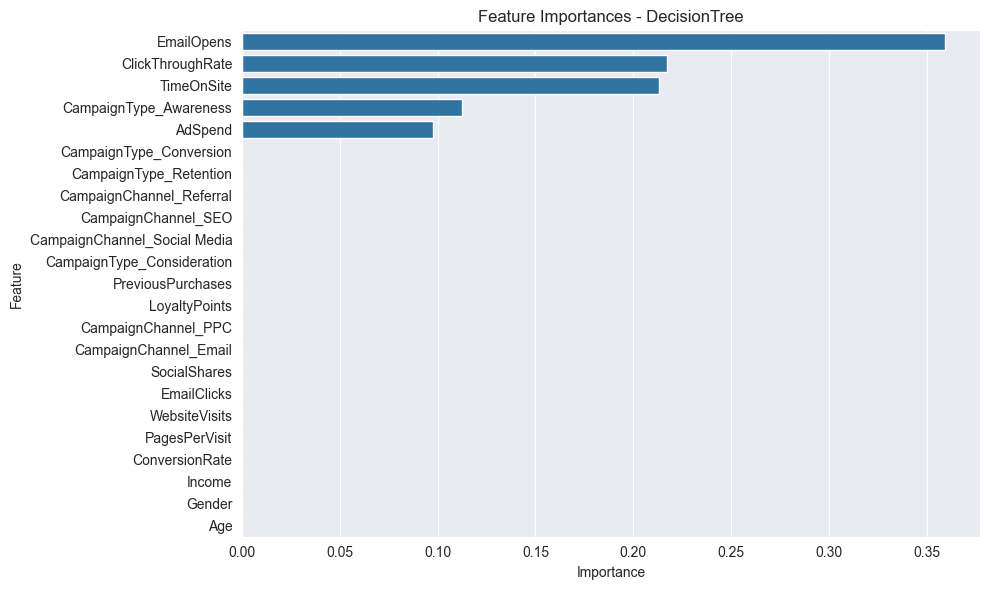


--- RandomForest ---
Age: 0.0408
Gender: 0.0314
Income: 0.0507
AdSpend: 0.0725
ClickThroughRate: 0.0757
ConversionRate: 0.0645
WebsiteVisits: 0.0546
PagesPerVisit: 0.0689
TimeOnSite: 0.0770
SocialShares: 0.0508
EmailOpens: 0.1056
EmailClicks: 0.0375
PreviousPurchases: 0.0609
LoyaltyPoints: 0.0731
CampaignChannel_Email: 0.0055
CampaignChannel_PPC: 0.0050
CampaignChannel_Referral: 0.0109
CampaignChannel_SEO: 0.0139
CampaignChannel_Social Media: 0.0175
CampaignType_Awareness: 0.0451
CampaignType_Consideration: 0.0235
CampaignType_Conversion: 0.0068
CampaignType_Retention: 0.0077


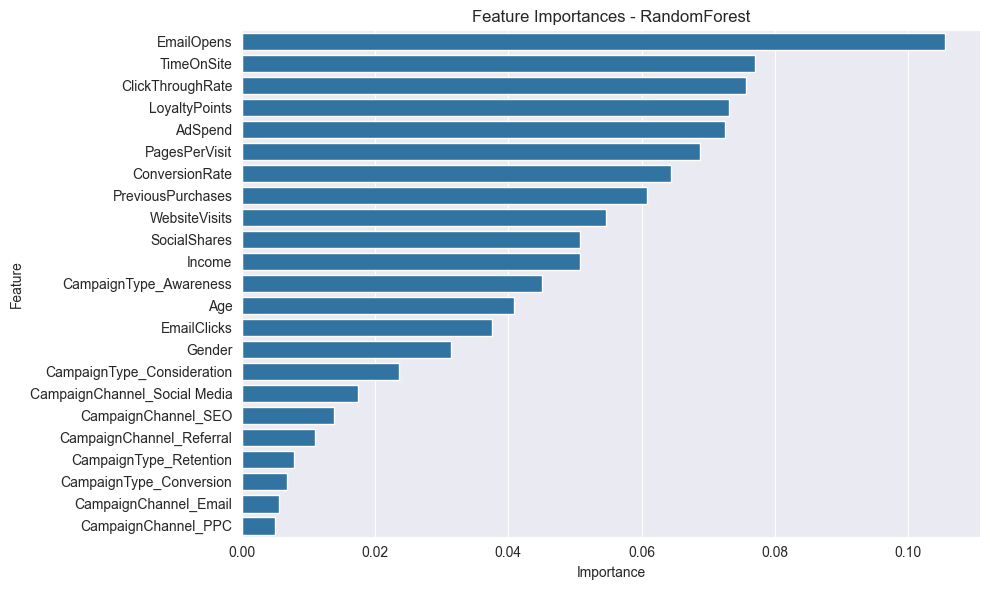


--- ExtraTrees ---
Age: 0.0288
Gender: 0.0512
Income: 0.0330
AdSpend: 0.0600
ClickThroughRate: 0.0386
ConversionRate: 0.0470
WebsiteVisits: 0.0354
PagesPerVisit: 0.0420
TimeOnSite: 0.0490
SocialShares: 0.0386
EmailOpens: 0.0763
EmailClicks: 0.0348
PreviousPurchases: 0.0704
LoyaltyPoints: 0.0443
CampaignChannel_Email: 0.0251
CampaignChannel_PPC: 0.0145
CampaignChannel_Referral: 0.0203
CampaignChannel_SEO: 0.0511
CampaignChannel_Social Media: 0.0475
CampaignType_Awareness: 0.0743
CampaignType_Consideration: 0.0610
CampaignType_Conversion: 0.0197
CampaignType_Retention: 0.0372


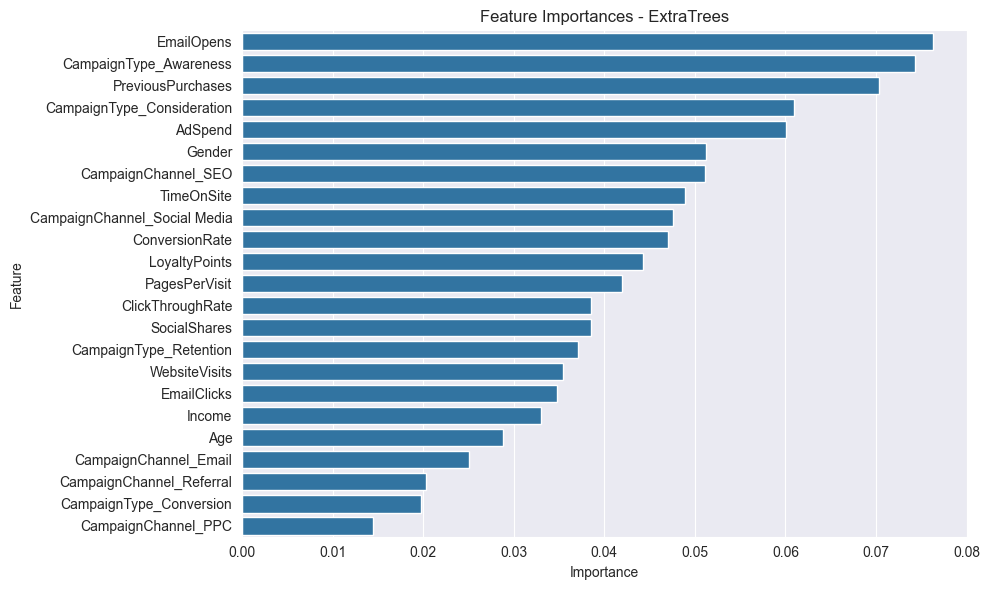


--- BaggingClassifier ---
Age: 0.0022
Gender: 0.0039
Income: 0.0008
AdSpend: 0.0215
ClickThroughRate: 0.0176
ConversionRate: 0.0140
WebsiteVisits: 0.0038
PagesPerVisit: 0.0009
TimeOnSite: 0.0326
SocialShares: 0.0029
EmailOpens: 0.0474
EmailClicks: 0.0128
PreviousPurchases: 0.0108
LoyaltyPoints: 0.0119
CampaignChannel_Email: 0.0014
CampaignChannel_PPC: 0.0015
CampaignChannel_Referral: 0.0031
CampaignChannel_SEO: 0.0027
CampaignChannel_Social Media: 0.0015
CampaignType_Awareness: 0.0089
CampaignType_Consideration: 0.0152
CampaignType_Conversion: -0.0002
CampaignType_Retention: 0.0020


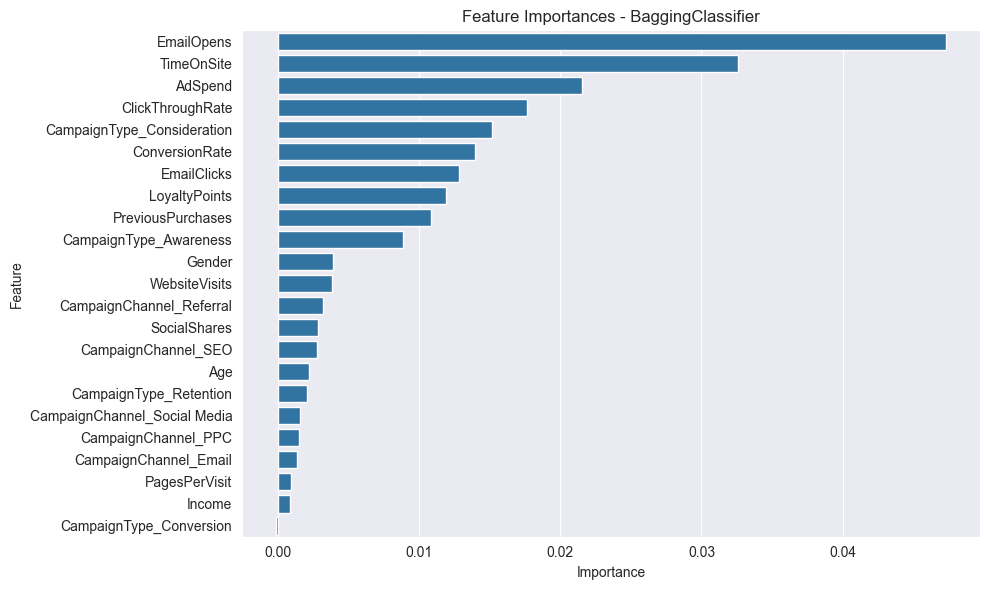


--- AdaBoost ---
Age: 0.0225
Gender: 0.0466
Income: 0.0000
AdSpend: 0.0733
ClickThroughRate: 0.1024
ConversionRate: 0.0951
WebsiteVisits: 0.0508
PagesPerVisit: 0.0536
TimeOnSite: 0.1128
SocialShares: 0.0000
EmailOpens: 0.1010
EmailClicks: 0.0517
PreviousPurchases: 0.0676
LoyaltyPoints: 0.1119
CampaignChannel_Email: 0.0202
CampaignChannel_PPC: 0.0000
CampaignChannel_Referral: 0.0000
CampaignChannel_SEO: 0.0000
CampaignChannel_Social Media: 0.0000
CampaignType_Awareness: 0.0295
CampaignType_Consideration: 0.0321
CampaignType_Conversion: 0.0000
CampaignType_Retention: 0.0289


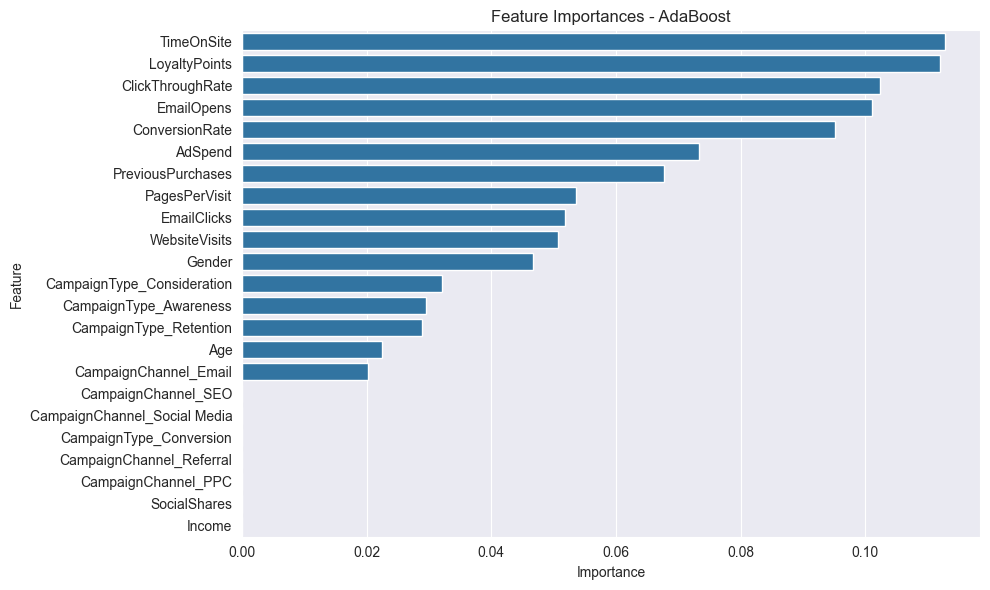


--- GradientBoosting ---
Age: 0.0119
Gender: 0.0196
Income: 0.0152
AdSpend: 0.0902
ClickThroughRate: 0.0904
ConversionRate: 0.0725
WebsiteVisits: 0.0105
PagesPerVisit: 0.0839
TimeOnSite: 0.1029
SocialShares: 0.0249
EmailOpens: 0.1784
EmailClicks: 0.0255
PreviousPurchases: 0.0896
LoyaltyPoints: 0.0525
CampaignChannel_Email: 0.0002
CampaignChannel_PPC: 0.0000
CampaignChannel_Referral: 0.0077
CampaignChannel_SEO: 0.0320
CampaignChannel_Social Media: 0.0022
CampaignType_Awareness: 0.0664
CampaignType_Consideration: 0.0191
CampaignType_Conversion: 0.0000
CampaignType_Retention: 0.0047


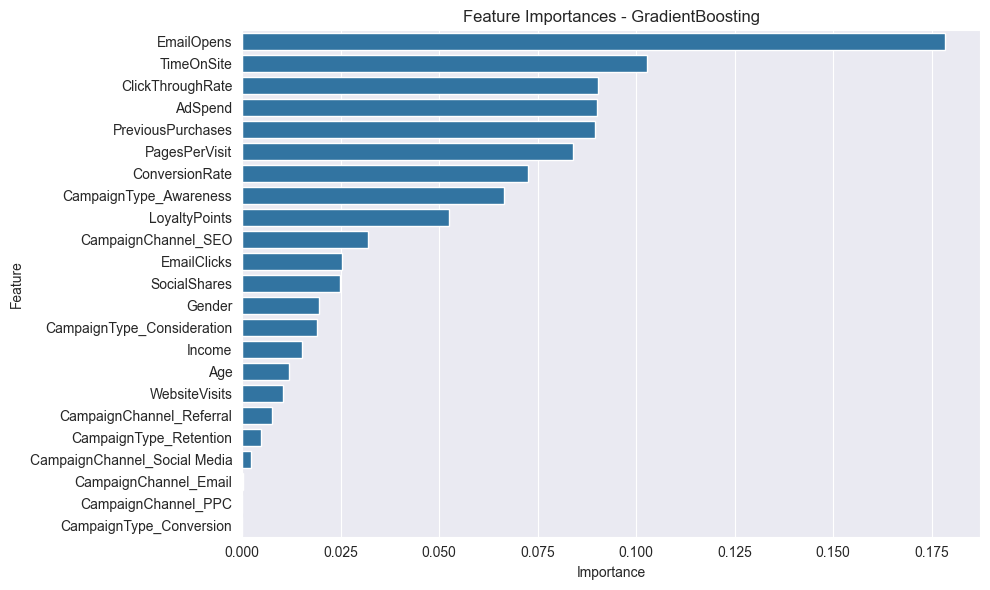


--- XGBoost ---
Age: 0.0274
Gender: 0.0254
Income: 0.0538
AdSpend: 0.0513
ClickThroughRate: 0.0527
ConversionRate: 0.0400
WebsiteVisits: 0.0310
PagesPerVisit: 0.0449
TimeOnSite: 0.0620
SocialShares: 0.0315
EmailOpens: 0.0917
EmailClicks: 0.0606
PreviousPurchases: 0.0420
LoyaltyPoints: 0.0286
CampaignChannel_Email: 0.0211
CampaignChannel_PPC: 0.0000
CampaignChannel_Referral: 0.0141
CampaignChannel_SEO: 0.0808
CampaignChannel_Social Media: 0.0224
CampaignType_Awareness: 0.0536
CampaignType_Consideration: 0.0620
CampaignType_Conversion: 0.0428
CampaignType_Retention: 0.0603


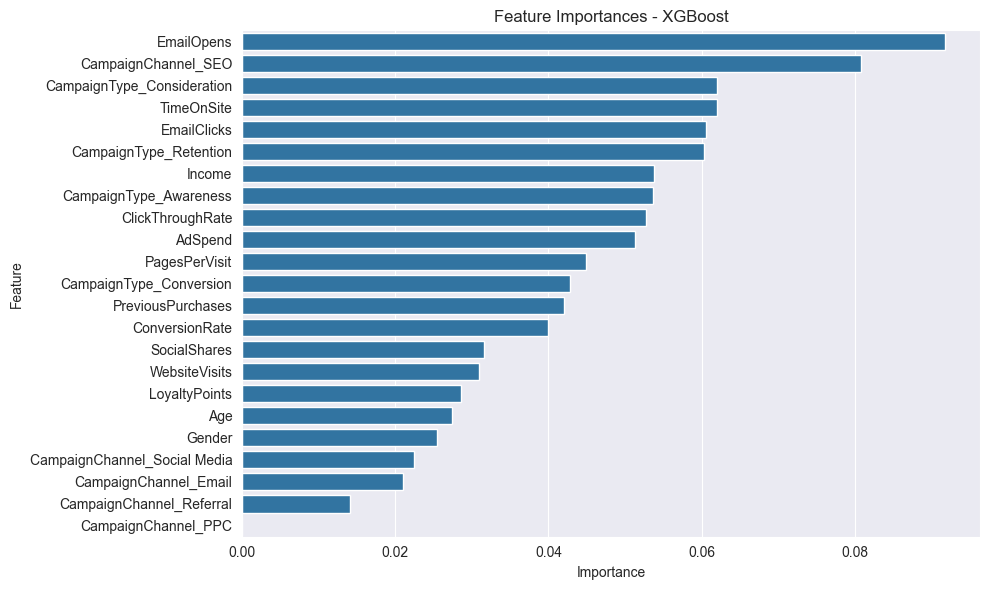


--- LightGBM ---
Age: 6.0000
Gender: 9.0000
Income: 3.0000
AdSpend: 25.0000
ClickThroughRate: 9.0000
ConversionRate: 19.0000
WebsiteVisits: 11.0000
PagesPerVisit: 22.0000
TimeOnSite: 27.0000
SocialShares: 14.0000
EmailOpens: 24.0000
EmailClicks: 3.0000
PreviousPurchases: 23.0000
LoyaltyPoints: 16.0000
CampaignChannel_Email: 9.0000
CampaignChannel_PPC: 0.0000
CampaignChannel_Referral: 8.0000
CampaignChannel_SEO: 9.0000
CampaignChannel_Social Media: 6.0000
CampaignType_Awareness: 20.0000
CampaignType_Consideration: 12.0000
CampaignType_Conversion: 0.0000
CampaignType_Retention: 4.0000


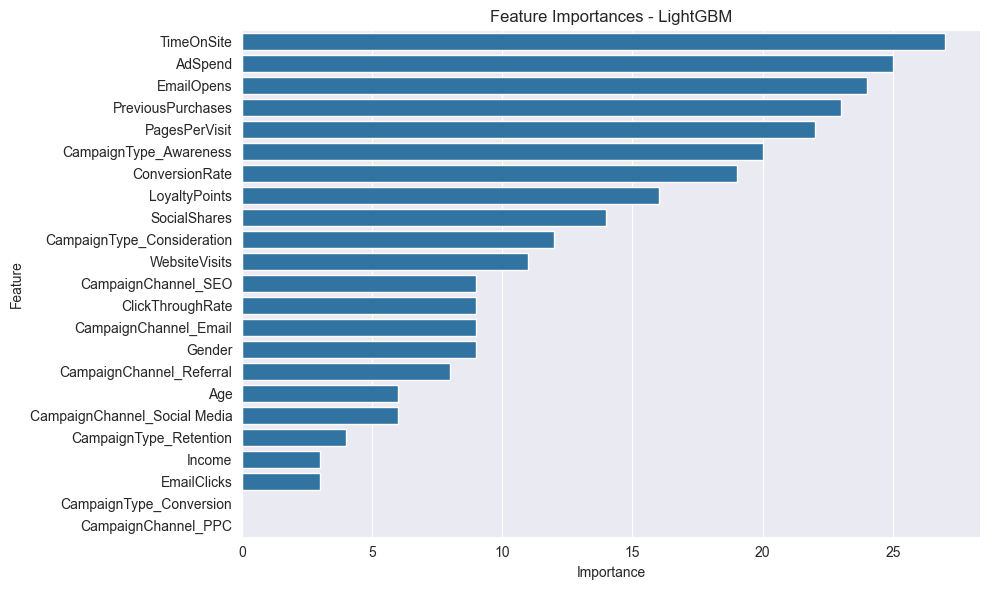


--- CatBoost ---
Age: 2.4837
Gender: 2.1486
Income: 2.5680
AdSpend: 7.2596
ClickThroughRate: 6.3544
ConversionRate: 5.0724
WebsiteVisits: 5.3939
PagesPerVisit: 5.6049
TimeOnSite: 7.5643
SocialShares: 4.0183
EmailOpens: 16.8519
EmailClicks: 3.9944
PreviousPurchases: 8.8378
LoyaltyPoints: 7.1722
CampaignChannel_Email: 0.3740
CampaignChannel_PPC: 0.1014
CampaignChannel_Referral: 0.2006
CampaignChannel_SEO: 0.8910
CampaignChannel_Social Media: 1.3279
CampaignType_Awareness: 5.5240
CampaignType_Consideration: 2.2601
CampaignType_Conversion: 1.6899
CampaignType_Retention: 2.3066


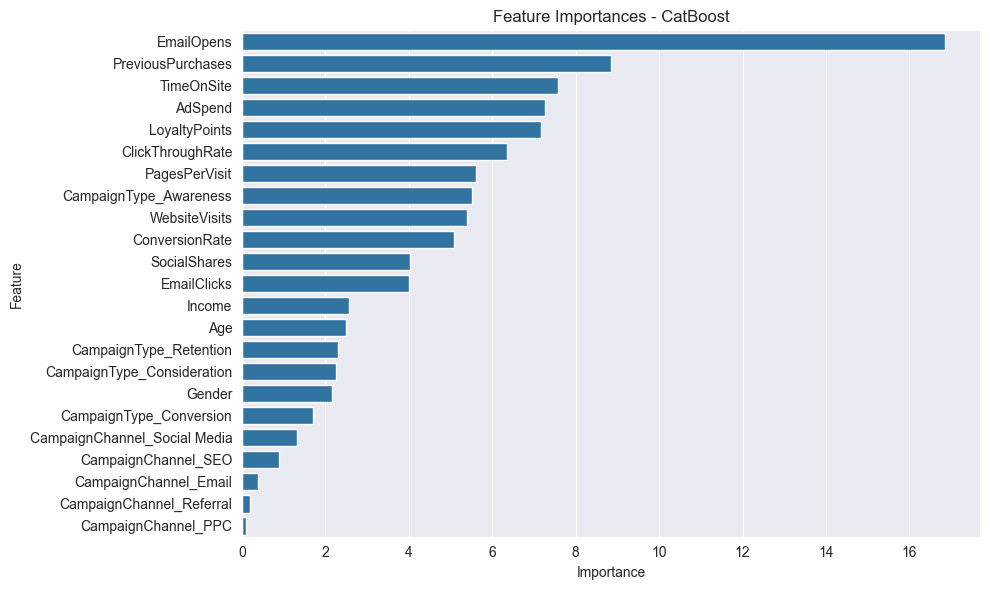


--- GaussianNB ---
Age: -0.0004
Gender: 0.0015
Income: -0.0036
AdSpend: 0.0345
ClickThroughRate: -0.0001
ConversionRate: 0.0000
WebsiteVisits: 0.0028
PagesPerVisit: 0.0068
TimeOnSite: 0.0301
SocialShares: 0.0001
EmailOpens: 0.0517
EmailClicks: 0.0279
PreviousPurchases: 0.0323
LoyaltyPoints: 0.0153
CampaignChannel_Email: 0.0004
CampaignChannel_PPC: 0.0008
CampaignChannel_Referral: 0.0014
CampaignChannel_SEO: 0.0010
CampaignChannel_Social Media: -0.0008
CampaignType_Awareness: 0.0014
CampaignType_Consideration: 0.0002
CampaignType_Conversion: 0.0008
CampaignType_Retention: 0.0029


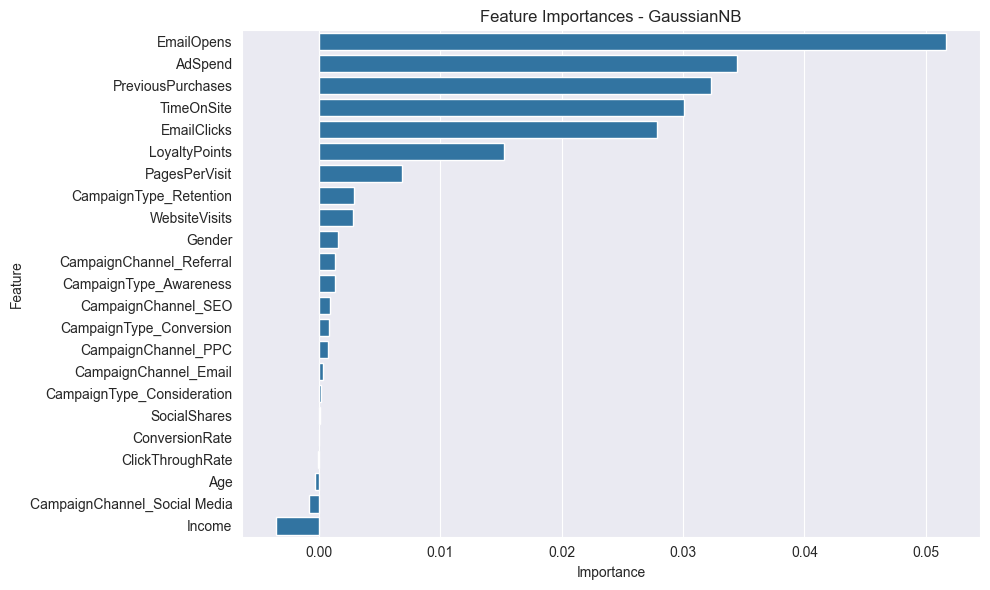


--- MultinomialNB ---
Age: 0.0005
Gender: -0.0001
Income: -0.0110
AdSpend: 0.0481
ClickThroughRate: 0.0000
ConversionRate: 0.0000
WebsiteVisits: -0.0003
PagesPerVisit: 0.0000
TimeOnSite: -0.0000
SocialShares: 0.0012
EmailOpens: 0.0003
EmailClicks: 0.0004
PreviousPurchases: 0.0004
LoyaltyPoints: 0.0166
CampaignChannel_Email: 0.0000
CampaignChannel_PPC: 0.0000
CampaignChannel_Referral: 0.0000
CampaignChannel_SEO: 0.0004
CampaignChannel_Social Media: 0.0004
CampaignType_Awareness: 0.0000
CampaignType_Consideration: -0.0001
CampaignType_Conversion: 0.0000
CampaignType_Retention: 0.0000


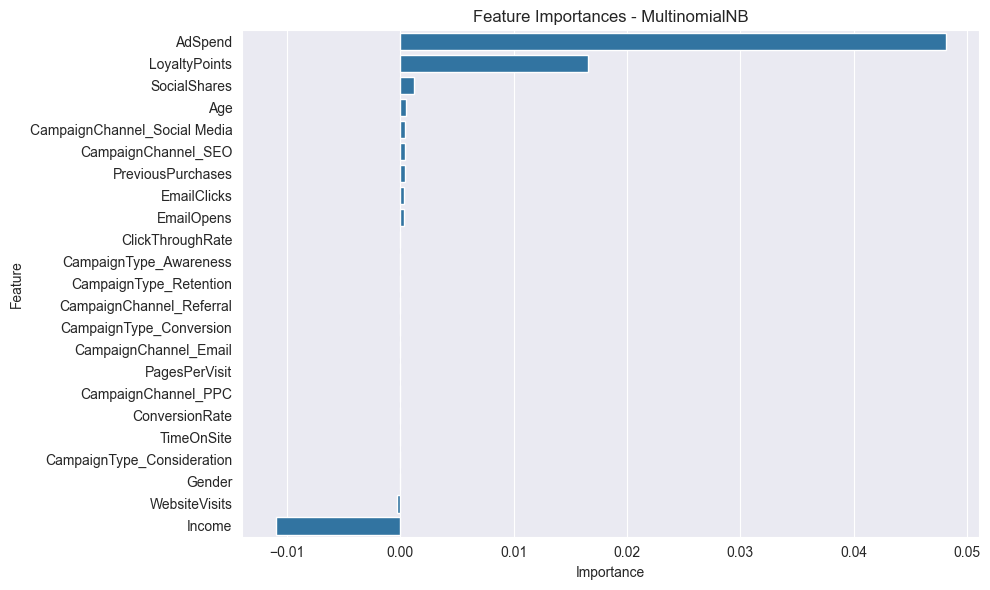


--- BernoulliNB ---
Age: 0.0000
Gender: 0.0342
Income: 0.0000
AdSpend: 0.0000
ClickThroughRate: 0.0000
ConversionRate: 0.0000
WebsiteVisits: -0.0002
PagesPerVisit: 0.0000
TimeOnSite: 0.0000
SocialShares: 0.0000
EmailOpens: -0.0068
EmailClicks: -0.0033
PreviousPurchases: 0.0110
LoyaltyPoints: 0.0000
CampaignChannel_Email: -0.0048
CampaignChannel_PPC: 0.0005
CampaignChannel_Referral: -0.0018
CampaignChannel_SEO: 0.0092
CampaignChannel_Social Media: 0.0137
CampaignType_Awareness: 0.0307
CampaignType_Consideration: 0.0335
CampaignType_Conversion: -0.0282
CampaignType_Retention: 0.0089


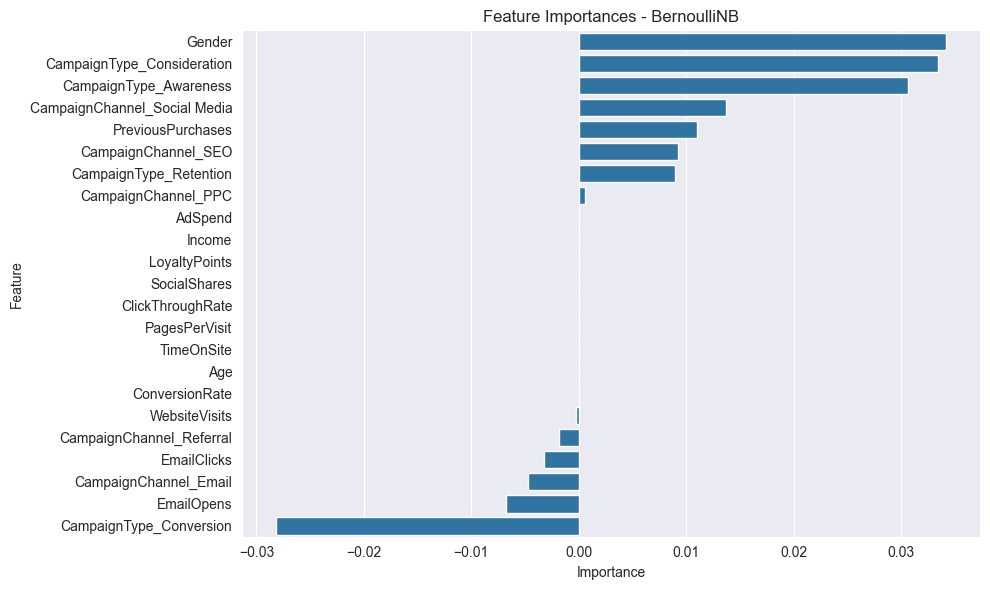


--- ComplementNB ---
Age: 0.0005
Gender: -0.0001
Income: -0.0110
AdSpend: 0.0481
ClickThroughRate: 0.0000
ConversionRate: 0.0000
WebsiteVisits: -0.0003
PagesPerVisit: 0.0000
TimeOnSite: -0.0000
SocialShares: 0.0012
EmailOpens: 0.0003
EmailClicks: 0.0004
PreviousPurchases: 0.0004
LoyaltyPoints: 0.0166
CampaignChannel_Email: 0.0000
CampaignChannel_PPC: 0.0000
CampaignChannel_Referral: 0.0000
CampaignChannel_SEO: 0.0004
CampaignChannel_Social Media: 0.0004
CampaignType_Awareness: 0.0000
CampaignType_Consideration: -0.0001
CampaignType_Conversion: 0.0000
CampaignType_Retention: 0.0000


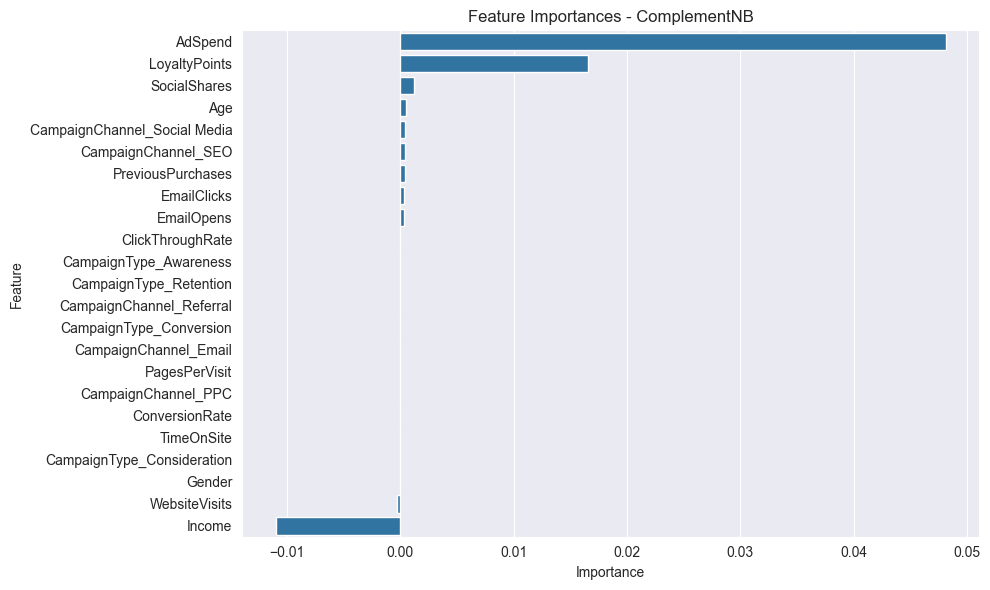


--- KNN ---
Age: 0.0000
Gender: 0.0000
Income: 0.0000
AdSpend: 0.0000
ClickThroughRate: 0.0000
ConversionRate: 0.0000
WebsiteVisits: 0.0000
PagesPerVisit: 0.0000
TimeOnSite: 0.0000
SocialShares: 0.0000
EmailOpens: 0.0000
EmailClicks: 0.0000
PreviousPurchases: 0.0000
LoyaltyPoints: 0.0000
CampaignChannel_Email: 0.0000
CampaignChannel_PPC: 0.0000
CampaignChannel_Referral: 0.0000
CampaignChannel_SEO: 0.0000
CampaignChannel_Social Media: 0.0000
CampaignType_Awareness: 0.0000
CampaignType_Consideration: 0.0000
CampaignType_Conversion: 0.0000
CampaignType_Retention: 0.0000


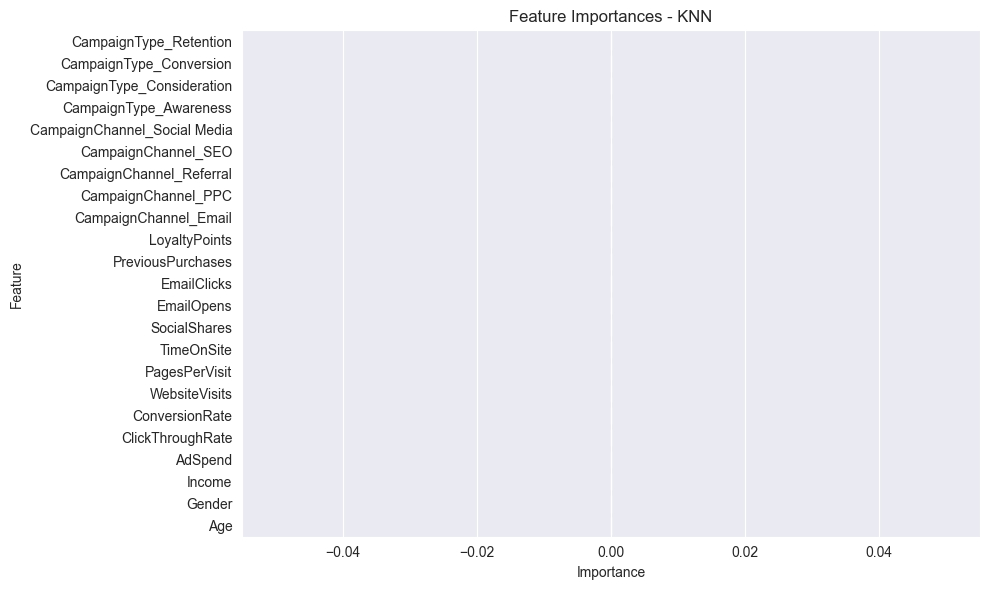


--- MLPClassifier ---
Age: 0.0000
Gender: 0.0000
Income: 0.0000
AdSpend: 0.0000
ClickThroughRate: 0.0000
ConversionRate: 0.0000
WebsiteVisits: 0.0000
PagesPerVisit: 0.0000
TimeOnSite: 0.0000
SocialShares: 0.0000
EmailOpens: 0.0000
EmailClicks: 0.0000
PreviousPurchases: 0.0000
LoyaltyPoints: 0.0000
CampaignChannel_Email: 0.0000
CampaignChannel_PPC: 0.0000
CampaignChannel_Referral: 0.0000
CampaignChannel_SEO: 0.0000
CampaignChannel_Social Media: 0.0000
CampaignType_Awareness: 0.0000
CampaignType_Consideration: 0.0000
CampaignType_Conversion: 0.0000
CampaignType_Retention: 0.0000


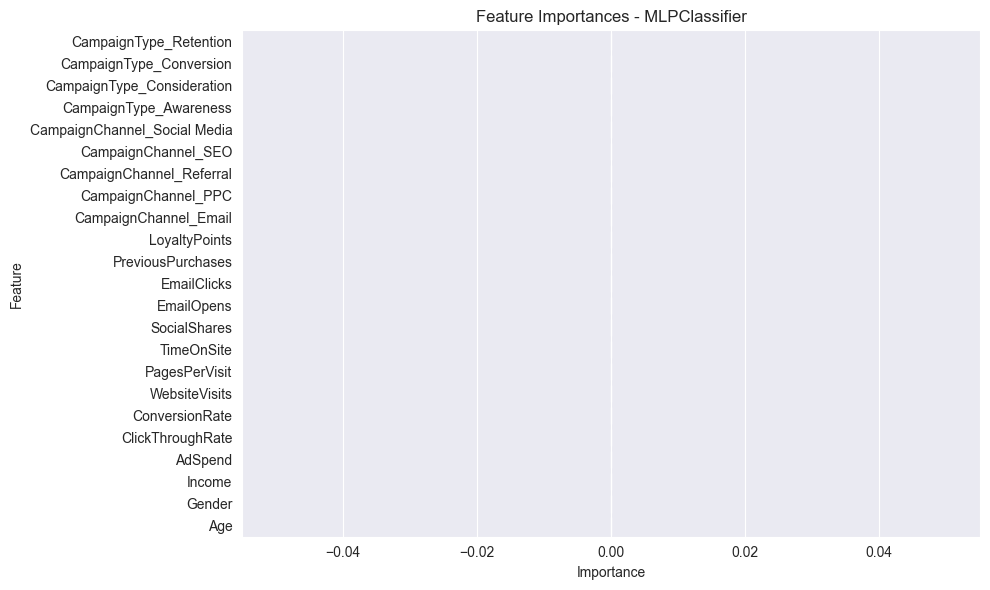


--- LDA ---
Age: -0.0507
Gender: 1.0138
Income: -0.0000
AdSpend: 0.0003
ClickThroughRate: 4.9692
ConversionRate: 18.2135
WebsiteVisits: 0.0487
PagesPerVisit: 0.2946
TimeOnSite: 0.4153
SocialShares: 0.0223
EmailOpens: 0.0737
EmailClicks: 0.2035
PreviousPurchases: 0.6171
LoyaltyPoints: 0.0002
CampaignChannel_Email: -6.9982
CampaignChannel_PPC: -3.8645
CampaignChannel_Referral: -6.6987
CampaignChannel_SEO: -6.1918
CampaignChannel_Social Media: -6.1877
CampaignType_Awareness: -4.4788
CampaignType_Consideration: -4.6071
CampaignType_Conversion: -2.3832
CampaignType_Retention: -1.8636


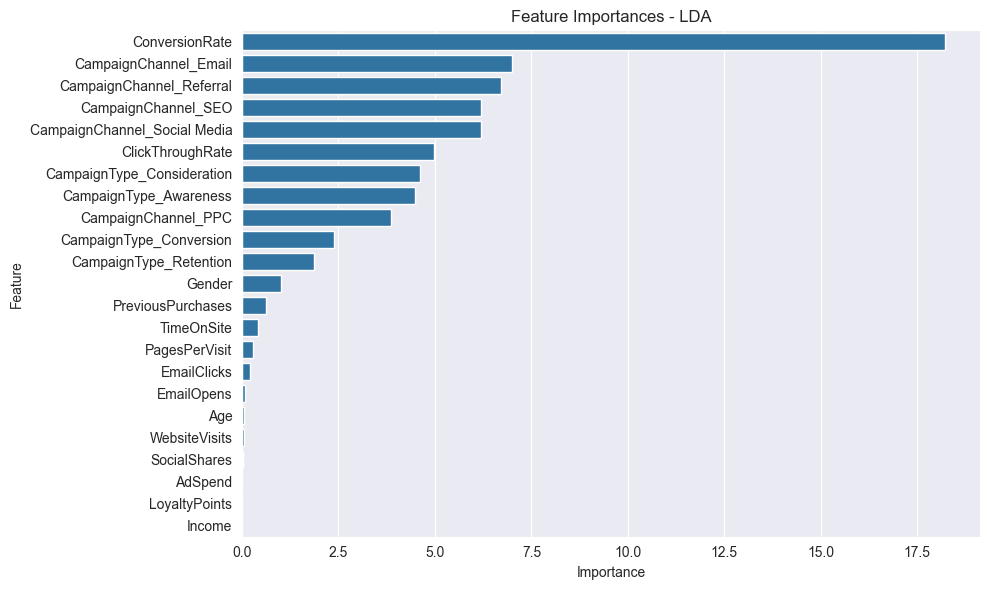


--- QDA ---
Age: -0.0005
Gender: -0.0013
Income: 0.0023
AdSpend: -0.0031
ClickThroughRate: -0.0002
ConversionRate: 0.0005
WebsiteVisits: -0.0005
PagesPerVisit: -0.0011
TimeOnSite: 0.0007
SocialShares: -0.0021
EmailOpens: -0.0015
EmailClicks: -0.0005
PreviousPurchases: 0.0017
LoyaltyPoints: 0.0020
CampaignChannel_Email: 0.1494
CampaignChannel_PPC: 0.1573
CampaignChannel_Referral: 0.1519
CampaignChannel_SEO: 0.1414
CampaignChannel_Social Media: 0.1566
CampaignType_Awareness: 0.1772
CampaignType_Consideration: 0.1816
CampaignType_Conversion: 0.1676
CampaignType_Retention: 0.1705


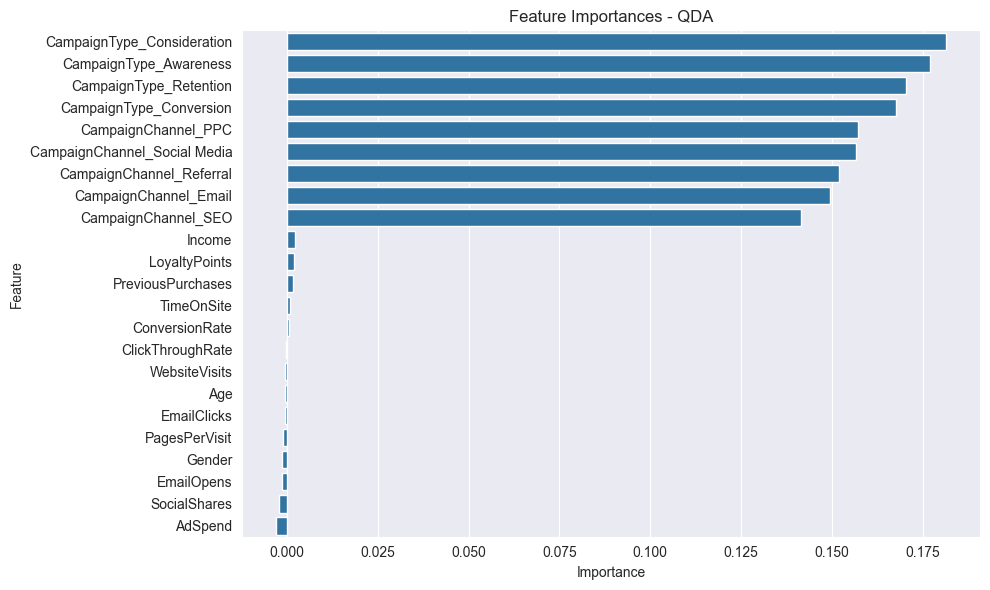

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.inspection import permutation_importance
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings for clean output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Assuming X_val and y_val are defined and `results` dict contains trained models
# The results dict should be like: {"ModelName": (best_estimator, accuracy), ...}

# Ensure X_val is a DataFrame (important for permutation importance)
if not isinstance(X_val, pd.DataFrame):
    X_val = pd.DataFrame(X_val, columns=X.columns)

feature_names = X.columns.tolist()

def plot_feature_importance(importances, model_name):
    importances = np.array(importances)
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
    plt.title(f"Feature Importances - {model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

for model_name, (model, _) in results.items():
    print(f"\n--- {model_name} ---")

    try:
        # If model has feature_importances_ (tree-based models)
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            for name, imp in zip(feature_names, importances):
                print(f"{name}: {imp:.4f}")
            plot_feature_importance(importances, model_name)

        # If model has coef_ (linear models)
        elif hasattr(model, "coef_"):
            coef = model.coef_
            if len(coef.shape) > 1:
                coef = coef[0]  # Binary classification
            importances = np.abs(coef)
            for name, imp in zip(feature_names, coef):
                print(f"{name}: {imp:.4f}")
            plot_feature_importance(importances, model_name)

        else:
            # Use permutation importance for models without direct importances
            result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
            importances = result.importances_mean
            for name, imp in zip(feature_names, importances):
                print(f"{name}: {imp:.4f}")
            plot_feature_importance(importances, model_name)

    except Exception as e:
        print(f"Could not compute importances for {model_name}: {str(e)}")
